# FinTime – Data Cleaning & Preparation
### Project: FinTime – Customer Financial Behavior & Health Intelligence System
### Author: Ujjwal Verma


## Objective
The objective of this notebook is to clean and standardize the raw transaction
dataset to make it analysis-ready.

This phase focuses on:
- Data type standardization
- Missing value treatment
- Feature derivation
- Outlier handling
- Final dataset validation

The output of this notebook is a clean dataset that will be used for SQL-based
aggregation, segmentation, and dashboard reporting.


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

## Load Raw Transaction Data

The raw transaction dataset is loaded as the input for cleaning operations.
This dataset is the same one validated during the data understanding phase.


In [ ]:
df = pd.read_csv("../../2_Data/Raw_Data/bank_transactions.csv")
df.head()

,TransactionID,CustomerID,CustomerDOB,CustGender,CustLocation,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR)
0,T1,C5841053,10/1/94,F,JAMSHEDPUR,17819.05,2/8/16,143207,25.0
1,T2,C2142763,4/4/57,M,JHAJJAR,2270.69,2/8/16,141858,27999.0
2,T3,C4417068,26/11/96,F,MUMBAI,17874.44,2/8/16,142712,459.0
3,T4,C5342380,14/9/73,F,MUMBAI,866503.21,2/8/16,142714,2060.0
4,T5,C9031234,24/3/88,F,NAVI MUMBAI,6714.43,2/8/16,181156,1762.5


## Date Field Standardization

Date fields are converted to datetime format to enable:
- Time-based analysis
- Accurate sorting and filtering
- Feature extraction in later stages


In [24]:
# Convert dates
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')

/var/folders/xl/zg7xr3f931ggd0w1xs4831280000gn/T/ipykernel_15736/655637789.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['TransactionDate'] = pd.to_datetime(df['TransactionDate'], errors='coerce')
/var/folders/xl/zg7xr3f931ggd0w1xs4831280000gn/T/ipykernel_15736/655637789.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['CustomerDOB'] = pd.to_datetime(df['CustomerDOB'], errors='coerce')


## Categorical Feature Optimization

Categorical fields are explicitly converted to category data type
to improve memory efficiency and consistency.


In [25]:
# Convert to category datatype
df['CustGender'] = df['CustGender'].astype('category')
df['CustLocation'] = df['CustLocation'].astype('category')

## Transaction Hour Extraction

Transaction time is transformed into an hour-level feature to support
time-based behavioral analysis.


In [26]:
# Convert transaction time to hour
df['TransactionHour'] = df['TransactionTime'] // 10000  # or extract differently if formatted differently

## Handling Missing Categorical Values

Missing demographic values are handled by introducing an explicit
'Unknown' category to preserve records without making assumptions.


In [27]:

# Add missing category before filling
df['CustGender'] = df['CustGender'].cat.add_categories(['Unknown'])
df['CustLocation'] = df['CustLocation'].cat.add_categories(['Unknown'])

In [28]:
# Fill missing values
df['CustGender'] = df['CustGender'].fillna('Unknown')
df['CustLocation'] = df['CustLocation'].fillna('Unknown')

## Handling Missing Numerical Values

Numerical missing values are filled using median imputation to
minimize the impact of extreme values and preserve distribution shape.


In [29]:
# Fill missing values
df['CustAccountBalance'] = df['CustAccountBalance'].fillna(df['CustAccountBalance'].median())

In [30]:
# Remove unrealistic DOBs
df.loc[df['CustomerDOB'] < '1920-01-01', 'CustomerDOB'] = pd.NaT
# Fill missing values
df['CustomerDOB'] = df['CustomerDOB'].fillna('Unknown')


### Missing Value Treatment Summary

- Demographic gaps were filled using category imputation ('Unknown')
- Numerical gaps were filled using median values to prevent distribution distortion


## Outlier Analysis – Transaction Amount

Outlier analysis is performed on transaction amounts to identify
extreme values that could distort revenue-based metrics.


Text(0.5, 1.0, 'Outlier Analysis - Transaction Amount')

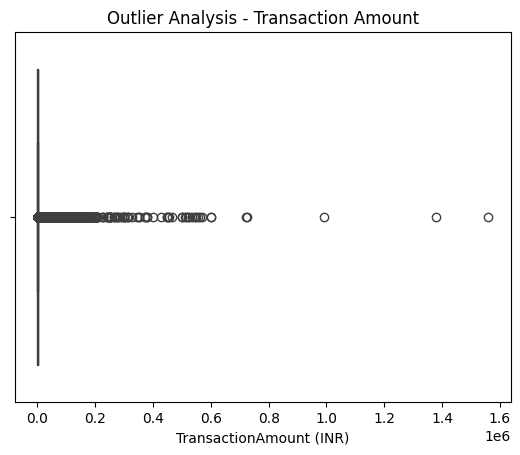

In [31]:
sns.boxplot(x=df['TransactionAmount (INR)'])
plt.title("Outlier Analysis - Transaction Amount")

## Outlier Handling Strategy

The Interquartile Range (IQR) method is used to remove extreme
high-value outliers while retaining the majority of valid transactions.


In [32]:
Q1 = df['TransactionAmount (INR)'].quantile(0.25)
Q3 = df['TransactionAmount (INR)'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df = df[(df['TransactionAmount (INR)'] >= lower_bound) & (df['TransactionAmount (INR)'] <= upper_bound)]

### Outlier Handling Summary

Extreme high-value transaction outliers were removed using the IQR rule
to improve data consistency and prevent skewed analytical results.


## Post-Cleaning Validation

After cleaning, the dataset is revalidated to ensure:
- No unexpected null values remain
- Data types are correct
- Dataset size is reasonable after filtering


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 936433 entries, 0 to 1048566
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   TransactionID            936433 non-null  object        
 1   CustomerID               936433 non-null  object        
 2   CustomerDOB              936433 non-null  object        
 3   CustGender               936433 non-null  category      
 4   CustLocation             936433 non-null  category      
 5   CustAccountBalance       936433 non-null  float64       
 6   TransactionDate          936433 non-null  datetime64[ns]
 7   TransactionTime          936433 non-null  int64         
 8   TransactionAmount (INR)  936433 non-null  float64       
 9   TransactionHour          936433 non-null  int64         
dtypes: category(2), datetime64[ns](1), float64(2), int64(2), object(3)
memory usage: 67.3+ MB


In [34]:
df.shape

(936433, 10)

In [35]:
df.describe()

,CustAccountBalance,TransactionDate,TransactionTime,TransactionAmount (INR),TransactionHour
count,9.364330e+05,936433,936433.000000,936433.000000,936433.000000
mean,9.508261e+04,2016-07-25 23:01:00.160630272,156779.062416,600.554787,15.380098
min,0.000000e+00,2016-01-08 00:00:00,0.000000,0.000000,0.000000
25%,4.348900e+03,2016-06-09 00:00:00,123415.000000,138.000000,12.000000
50%,1.525307e+04,2016-08-20 00:00:00,164131.000000,357.000000,16.000000
75%,4.993698e+04,2016-09-09 00:00:00,200210.000000,882.860000,20.000000
max,1.150355e+08,2016-12-09 00:00:00,235959.000000,2758.390000,23.000000
std,6.529616e+05,NaN,51747.436240,627.568528,5.175502


In [36]:
df.isnull().sum()

TransactionID              0
CustomerID                 0
CustomerDOB                0
CustGender                 0
CustLocation               0
CustAccountBalance         0
TransactionDate            0
TransactionTime            0
TransactionAmount (INR)    0
TransactionHour            0
dtype: int64

## Column Name Standardization

Column names are standardized to remove special characters
and ensure compatibility with SQL and BI tools.


In [38]:
df.rename(columns={'TransactionAmount (INR)': 'TransactionAmountINR'}, inplace=True)

## Export Cleaned Dataset

The cleaned dataset is saved and used as the official input for:
- SQL transformation
- Feature engineering
- Segmentation and churn analysis


In [39]:
df.to_csv("../../2-Data/Cleaned_Data/transactions_cleaned.csv", index=False)

## Data Cleaning Completion Summary

- Data types were standardized for dates, categories, and numerical fields
- Missing values were handled using business-appropriate strategies
- Outliers were removed using a robust statistical method
- Cleaned dataset was exported for downstream SQL and BI analysis

The dataset is now fully prepared for feature engineering,
segmentation, and dashboard development.
